# A/B Testing Case Study with Audacity

## Table of contents<a id='toc'></a>

1. [Overview](#overview)
2. [Packages](#package)
3. [Experiment](#experiment)
    1. [Homepage re-design](#homepage)
    2. [Course description re-design](#cDescription)
        1. [Enrollment rate](#enroll_rate)
        2. [Average reading duration](#avg_reading)
        3. [Average classroom time](#avg_classroom)
        4. [Completion rate](#completion)
        5. [Analyzing multiple metrics](#multiple_metrics)
4. [Difficulties in A/B Testing](#difficulties)
    1. [Scenario 1](#s1)
    2. [Scenario 2](#s2)
    3. [Scenario 3](#s3)
    4. [Common factors to consider](#common_factor)

## Overview <a id='overview'></a>

In this case study, we’ll analyze A/B test results for Audacity. Here's the customer funnel for typical new users on their site:

<strong><center>View home page > Explore courses > View course overview page > Enroll in course > Complete course</center></strong>

<img src="image/user_flow.png" width="300">

Audacity loses users as they go down the stages of this funnel, with only a few making it to the end. To increase student engagement, Audacity is performing A/B tests to try out changes that will hopefully increase conversion rates from one stage to the next.

We’ll analyze test results for two changes they have in mind, and then make a recommendation on whether they should launch each change.

## Packages <a id='package'></a>
* `Pandas`, `Numpy` for data manipulation
* `Matplotlib.pyplot`, `Seaborn` for data visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Experiment <a id='experiment'></a>

### Homepage re-design <a id='homepage'></a>

The first change Audacity wants to try is on their homepage. They hope that this new, more engaging design will increase the number of users that explore their courses, that is, move on to the second stage of the funnel.

Current Home Page | New Home Page
- | - 
<img src="image/current_home_page.png" width="300"> | <img src="image/new_home_page.png" width="300"> 

The metric we will use is the click through rate for the Explore Courses button on the home page. **Click through rate (CTR)** is often defined as the the number of clicks divided by the number of views. Since Audacity uses cookies, we can identify unique users and make sure we don't count the same one multiple times. For this experiment, we'll define our click through rate as:

<strong><center>CTR: # clicks by unique users / # views by unique users</center></strong>

Now that we have our metric, let's set up our null and alternative hypotheses:

$$H_0: CTR_{new} \leq CTR _{old}$$

$$H_1: CTR_{new} > CTR _{old}$$

Our alternative hypothesis is what we want to prove to be true, in this case, that the new homepage design has a higher click through rate than the old homepage design. And the null hypothesis is what we assume to be true before analyzing data, which is that the new homepage design has a click through rate that is less than or equal to that of the old homepage design. As you’ve seen before, we can rearrange our hypotheses to look like this:

$$H_0: CTR_{new} - CTR_{old} \leq 0$$

$$H_1: CTR_{new} - CTR_{old} > 0$$

We use click through rate instead of number of clicks to compare the performances of control and experiment pages is mainly because:

1. The control and experiment pages could have different numbers of total visitors.

2. More total clicks could occur in one version, even if there is a greater percentage of clicks in the other version.

We define the click through rate in this experiment as: **The number of unique visitors who click at least once divided by the number of unique visitors who view the page**.

In [2]:
df = pd.read_csv('data/homepage_actions.csv')
df.head()

,timestamp,id,group,action
0,2016-09-24 17:42:27.839496,804196,experiment,view
1,2016-09-24 19:19:03.542569,434745,experiment,view
2,2016-09-24 19:36:00.944135,507599,experiment,view
3,2016-09-24 19:59:02.646620,671993,control,view
4,2016-09-24 20:26:14.466886,536734,experiment,view


##### Some basic statistics of the experiment

In [3]:
print('The experiment started at {}, and ended at {} for about 4 months.'.format(df.timestamp.min()[:10], df.timestamp.max()[:10]))

The experiment started at 2016-09-24, and ended at 2017-01-18 for about 4 months.


In [4]:
print(f'The actions recorded are {df.action.unique()[0]} and {df.action.unique()[1]}.')

The actions recorded are view and click.


In [5]:
print('Total number of actions: {}'.format(df.shape[0]))
print('Number of unique users: {}'.format(df.id.nunique()))
print('Control group size: {}'.format(df.query('group == "control"').id.nunique()))
print('Experiment group size: {}'.format(df.query('group == "experiment"').id.nunique()))

Total number of actions: 8188
Number of unique users: 6328
Control group size: 3332
Experiment group size: 2996


##### Does the experiment page drive higher traffic than the control page?

In [6]:
control_df = df.query('group == "control"')
control_ctr = control_df.query('action == "click"').id.nunique() / control_df.query('action == "view"').id.nunique()
print(f'The control group CTR is about {control_ctr:.5f}.')

The control group CTR is about 0.27971.


In [7]:
experiment_df = df.query('group == "experiment"')
experiment_ctr = experiment_df.query('action == "click"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
print(f'The experiment group CTR is about {experiment_ctr:.5f}.')

The experiment group CTR is about 0.30975.


* **We computed the observed difference between the metric, click through rate, for the control and experiment group.**

In [8]:
obs_diff = experiment_ctr - control_ctr
print(f'The observed difference is about {obs_diff:.5f}.')

The observed difference is about 0.03003.


* **We simulated the sampling distribution for the difference in proportions (or difference in click through rates).**

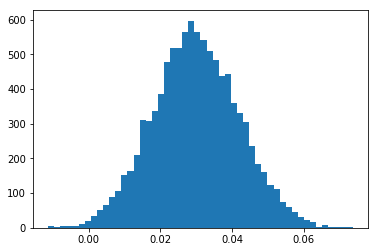

In [9]:
diffs = []
for _ in range(10000):
    b_sample = df.sample(df.shape[0], replace=True) #bootstrap sampling
    control_df = b_sample.query('group == "control"')
    experiment_df = b_sample.query('group == "experiment"')
    control_ctr = control_df.query('action == "click"').id.nunique() / control_df.query('action == "view"').id.nunique()
    experiment_ctr = experiment_df.query('action == "click"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
    diffs.append(experiment_ctr - control_ctr)
diffs = np.array(diffs)
plt.hist(diffs, bins=50);

* **We used this sampling distribution to simulate the distribution under the null hypothesis, by creating a random normal distribution centered at 0 with the same spread and size.**

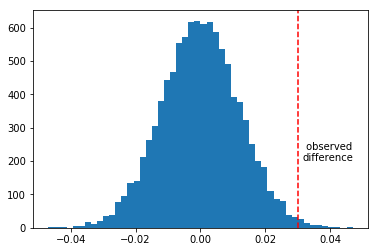

In [10]:
np.random.seed(42)
null_vals = np.random.normal(0, diffs.std(), diffs.size)

ax = plt.hist(null_vals, bins=50)
plt.axvline(x=obs_diff, color='red', linestyle='--')
plt.text(x = obs_diff*1.05, y = ax[0].mean(), s=' observed\ndifference');

* **We computed the p-value by finding the proportion of values in the null distribution that were greater than our observed difference.**

In [11]:
p_value = (null_vals > obs_diff).mean()
print(f'The p-value is {p_value:.5f}')

The p-value is 0.00660


* **We used this p-value to determine the statistical significance of our observed difference.**

**With a type I error rate of 0.05, we reject the null hypothesis, and decide to implement the new (experiment) homepage.**

### Course description re-design <a id='cDescription'></a>

The second change Audacity is A/B testing is a more career focused description on a course overview page. They hope that this change may encourage more users to enroll and complete this course. 

Current Course Description | New Course Description
- | - 
<img src="image/current_course_page.png" width="300"> | <img src="image/new_course_page.png" width="300"> 

In this experiment, we’re going to analyze the following metrics:

1. **Enrollment Rate:** Click through rate for the Enroll button the course overview page
2. **Average Reading Duration:** Average number of seconds spent on the course overview page
3. **Average Classroom Time:** Average number of days spent in the classroom for students enrolled in the course
4. **Completion Rate:** Course completion rate for students enrolled in the course

In [12]:
p_values = [] # we initialize a list to store p-values of each experiment.

First, let's determine if the difference observed for each metric is statistically significant individually.

#### Enrollment Rate <a id='enroll_rate'></a>

In [13]:
df = pd.read_csv('data/course_page_actions.csv')
df.head()

,timestamp,id,group,action,duration
0,2016-09-24 17:14:52.012145,261869,experiment,view,130.545004
1,2016-09-24 18:45:09.645857,226546,experiment,view,159.862440
2,2016-09-24 19:16:21.002533,286353,experiment,view,79.349315
3,2016-09-24 19:43:06.927785,842279,experiment,view,55.536126
4,2016-09-24 21:08:22.790333,781883,experiment,view,204.322437


##### Some basic statistics of the experiment

In [14]:
print('The experiment started at {}, and ended at {} for about 4 months.'.format(df.timestamp.min()[:10], df.timestamp.max()[:10]))

The experiment started at 2016-09-24, and ended at 2017-01-18 for about 4 months.


In [15]:
print(f'The actions recorded are {df.action.unique()[0]} and {df.action.unique()[1]}.')

The actions recorded are view and enroll.


In [16]:
print('Total number of actions: {}'.format(df.shape[0]))
print('Number of unique users: {}'.format(df.id.nunique()))
print('Control group size: {}'.format(df.query('group == "control"').id.nunique()))
print('Experiment group size: {}'.format(df.query('group == "experiment"').id.nunique()))

Total number of actions: 4074
Number of unique users: 4028
Control group size: 1949
Experiment group size: 2079


In [17]:
control_df = df.query('group == "control"')
control_ctr = control_df.query('action == "enroll"').id.nunique() / control_df.query('action == "view"').id.nunique()
print(f'The control group enrollment rate is about {control_ctr:.5f}.')

The control group enrollment rate is about 0.23644.


In [18]:
experiment_df = df.query('group == "experiment"')
experiment_ctr = experiment_df.query('action == "enroll"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
print(f'The experiment group enrollment rate is about {experiment_ctr:.5f}.')

The experiment group enrollment rate is about 0.26687.


In [19]:
obs_diff = experiment_ctr - control_ctr
print(f'The observed difference is about {obs_diff:.5f}.')

The observed difference is about 0.03043.


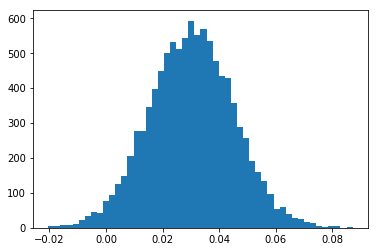

In [20]:
diffs = []
for _ in range(10000):
    b_sample = df.sample(df.shape[0], replace=True) #bootstrap sampling
    control_df = b_sample.query('group == "control"')
    experiment_df = b_sample.query('group == "experiment"')
    control_ctr = control_df.query('action == "enroll"').id.nunique() / control_df.query('action == "view"').id.nunique()
    experiment_ctr = experiment_df.query('action == "enroll"').id.nunique() / experiment_df.query('action == "view"').id.nunique()
    diffs.append(experiment_ctr - control_ctr)
diffs = np.array(diffs)
plt.hist(diffs, bins=50);

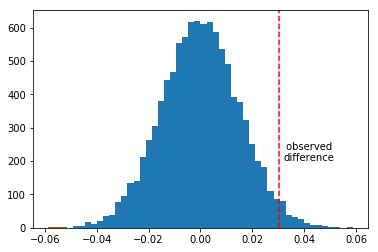

In [21]:
np.random.seed(42)
null_vals = np.random.normal(0, diffs.std(), diffs.size)

ax = plt.hist(null_vals, bins=50)
plt.axvline(x=obs_diff, color='red', linestyle='--')
plt.text(x=obs_diff*1.05, y=ax[0].mean(), s=' observed\ndifference');

In [22]:
p_value = (null_vals > obs_diff).mean()
p_values.append(p_value)
print(f'The p-value is {p_value:.5f}')

The p-value is 0.02230


**With a type I error rate of 0.05, we reject the null hypothesis.**

#### Average Reading Duration <a id='avg_reading'></a>

In [23]:
views = df.query('action == "view"')
reading_times = views.groupby(['id','group'])['duration'].mean()
reading_times = reading_times.reset_index()
reading_times.head()

,id,group,duration
0,183260,control,107.331484
1,183615,experiment,24.627594
2,184277,experiment,193.212489
3,184360,experiment,226.586283
4,184589,experiment,12.052097


In [24]:
control_mean = df.query('group == "control"')['duration'].mean()
experiment_mean = df.query('group == "experiment"')['duration'].mean()
print(f'The average view time for control group is {control_mean:.2f} seconds.\n\
The average view time for experiment group is {experiment_mean:.2f} seconds.')

The average view time for control group is 115.41 seconds.
The average view time for experiment group is 130.93 seconds.


In [25]:
obs_diff = experiment_mean - control_mean
print(f'The observed difference is about {obs_diff:.3f}.')

The observed difference is about 15.525.


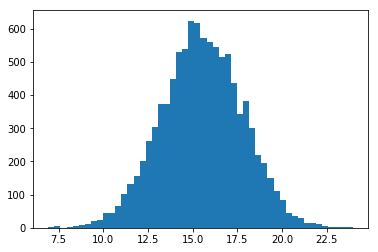

In [26]:
diffs = []
for _ in range(10000):
    b_sample = df.sample(df.shape[0], replace=True) #bootstrap sampling
    control_mean = b_sample.query('group == "control"')['duration'].mean()
    experiment_mean = b_sample.query('group == "experiment"')['duration'].mean()
    diffs.append(experiment_mean - control_mean)
diffs = np.array(diffs)
plt.hist(diffs, bins=50);

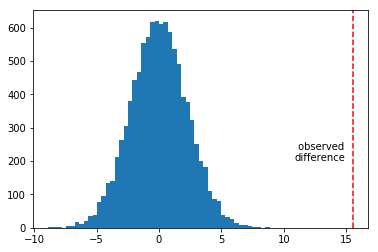

In [27]:
np.random.seed(42)
null_vals = np.random.normal(0, diffs.std(), diffs.size)

ax = plt.hist(null_vals, bins=50)
plt.axvline(x=obs_diff, color='red', linestyle='--')
plt.text(x=obs_diff*.7, y=ax[0].mean(), s=' observed\ndifference');

In [28]:
p_value = (null_vals > obs_diff).mean()
p_values.append(p_value)
print(f'The p-value is {p_value:.5f}')

The p-value is 0.00000


**With a type I error rate of 0.05, we reject the null hypothesis.**

#### Average Classroom Time <a id='avg_classroom'></a>

In [29]:
df = pd.read_csv('data/classroom_actions.csv')
df.head()

,timestamp,id,group,total_days,completed
0,2015-08-10 17:06:01.032740,610019,experiment,97,True
1,2015-08-10 17:15:28.950975,690224,control,75,False
2,2015-08-10 17:34:40.920384,564994,experiment,128,True
3,2015-08-10 17:50:39.847374,849588,experiment,66,False
4,2015-08-10 19:10:40.650599,849826,experiment,34,False


##### Some basic statistics of the experiment

In [30]:
print('The experiment started at {}, and ended at {} for about 4 months.'.format(df.timestamp.min()[:10], df.timestamp.max()[:10]))

The experiment started at 2015-08-10, and ended at 2016-01-19 for about 4 months.


In [31]:
print('Total number of actions: {}'.format(df.shape[0]))
print('Number of unique users: {}'.format(df.id.nunique()))
print('Control group size: {}'.format(df.query('group == "control"').id.nunique()))
print('Experiment group size: {}'.format(df.query('group == "experiment"').id.nunique()))

Total number of actions: 3829
Number of unique users: 3829
Control group size: 1664
Experiment group size: 2165


In [32]:
control_mean = df.query('group == "control"').total_days.mean()
experiment_mean = df.query('group == "experiment"').total_days.mean()
print(f'The average classroom time for control group is {control_mean:.2f} days\n\
The average classroom time for experiment group is {experiment_mean:.2f} days.')

The average classroom time for control group is 73.37 days
The average classroom time for experiment group is 74.67 days.


In [33]:
obs_diff = experiment_mean - control_mean
print(f'The observed difference is about {obs_diff:.3f}.')

The observed difference is about 1.303.


In [34]:
diffs = []
for _ in range(10000):
    b_sample = df.sample(df.shape[0], replace=True) #bootstrap sampling
    control_mean = b_sample.query('group == "control"')['total_days'].mean()
    experiment_mean = b_sample.query('group == "experiment"')['total_days'].mean()
    diffs.append(experiment_mean - control_mean)
diffs = np.array(diffs)
# plt.hist(diffs, bins=50);

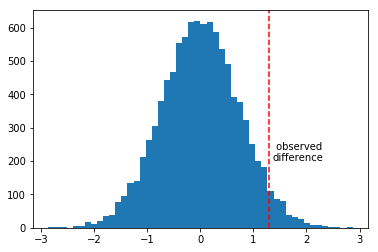

In [35]:
np.random.seed(42)
null_vals = np.random.normal(0, diffs.std(), diffs.size)

ax = plt.hist(null_vals, bins=50)
plt.axvline(x=obs_diff, color='red', linestyle='--')
plt.text(x=obs_diff*1.05, y=ax[0].mean(), s=' observed\ndifference');

In [36]:
p_value = (null_vals > obs_diff).mean()
p_values.append(p_value)
print(f'The p-value is {p_value:.5f}')

The p-value is 0.03740


**With a type I error rate of 0.05, we reject the null hypothesis.**

**Practically significant?**

Even if the increase in classroom time is statistically significant, engaging students for 1.3 more days in the classroom, when they average around 74 days in total, doesn't seem to indicate a large enough value to launch this change from a practical perspective for Audacity.

#### Completion Rate <a id='completion'></a>

In [37]:
control_df = df.query('group == "control"')
control_ctr = control_df.completed.mean()
print(f'The control group completion rate is about {control_ctr:.5f}.')

The control group completion rate is about 0.37200.


In [38]:
experiment_df = df.query('group == "experiment"')
experiment_ctr = experiment_df.completed.mean()
print(f'The experiment group completion rate is about {experiment_ctr:.5f}.')

The experiment group completion rate is about 0.39353.


In [39]:
obs_diff = experiment_ctr - control_ctr
print(f'The observed difference is about {obs_diff:.3f}.')

The observed difference is about 0.022.


In [40]:
diffs = []
for _ in range(10000):
    b_sample = df.sample(df.shape[0], replace=True) #bootstrap sampling
    control_mean = b_sample.query('group == "control"')['completed'].mean()
    experiment_mean = b_sample.query('group == "experiment"')['completed'].mean()
    diffs.append(experiment_mean - control_mean)
diffs = np.array(diffs)
# plt.hist(diffs, bins=50);

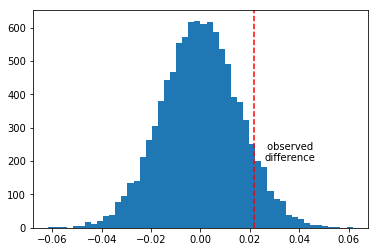

In [41]:
np.random.seed(42)
null_vals = np.random.normal(0, diffs.std(), diffs.size)

ax = plt.hist(null_vals, bins=50)
plt.axvline(x=obs_diff, color='red', linestyle='--')
plt.text(x=obs_diff*1.2, y=ax[0].mean(), s=' observed\ndifference');

In [42]:
p_value = (null_vals > obs_diff).mean()
p_values.append(p_value)
print(f'The p-value is {p_value:.5f}')

The p-value is 0.08610


**With a type I error rate of 0.05, we cannot reject the null hypothesis.**

#### Analyzing multiple metrics <a id='multiple_metrics'></a>

The more metrics you evaluate, the more likely you are to observe significant differences just by chance. This [**multiple comparisions problem**](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) can be handled in several ways.

One common way is the [**Bonferroni Correction**](https://en.wikipedia.org/wiki/Bonferroni_correction). If our original alpha value was 0.05, with four tests, we should choose our new Bonferroni corrected alpha value to be $0.05/4 = 0.0125$.

Given our 4 p-values of the 4 tests:

In [43]:
metrics = ['Enrollment Rate', 'Average Reading Duration', 'Average Classroom Time', 'Completion Rate']
for i, pvalue in enumerate(p_values):
    print(f'{metrics[i]}: {pvalue:.4f}')

Enrollment Rate: 0.0223
Average Reading Duration: 0.0000
Average Classroom Time: 0.0374
Completion Rate: 0.0861


We can only be sure that the `Average reading duration` is statistically significant.

Since the Bonferroni method is too conservative when we expect correlation among metrics, we can better approach this problem with more sophisticated methods, such as the [**closed testing procedure**](https://en.wikipedia.org/wiki/Closed_testing_procedure), [**Boole-Bonferroni bound**](https://en.wikipedia.org/wiki/Boole%27s_inequality), and the [**Holm-Bonferroni method**](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method). These are less conservative and take this correlation into account.

If you do choose to use a less conservative method, just make sure the assumptions of that method are truly met in your situation, and that you're not just trying to cheat on a p-value. Choosing a poorly suited test just to get significant results will only lead to misguided decisions that harm your company's performance in the long run.

## Difficulties in A/B Testing <a id='difficulties'></a>

Being able to determine the statistical significance of performance differences in A/B test results is valuable. However, there are many other factors to consider to ensure your A/B tests are successful. In the real world, designing, running, and drawing conclusions from an A/B test to lead you to the right decisions can be tricky.

We will take a look at three scenarios where Audacity conducted an A/B test that led to a poor decision.

### Scenario 1: <a id='s1'></a>

**EXPERIMENT:** Audacity tests a new layout in the classroom to see if it would help engage students. After running an A/B test for two weeks, they find that average classroom times and completion rates decrease with the new layout, and decide against launching the change.

**REALITY:** What they don't know, is that the classroom times and completion rates actually increase significantly for new students using the new layout. In the long run, the layout would help existing students too, but they are currently experiencing change aversion.

**POTENTIAL REASON(S):**

1. The experiment included existing users who would bias results in a short time frame.
2. The experiment wasn't run long enough to allow existing users to adjust to the change.

In order to protect against change aversion, we need to run the experiment long enough for existing users to acclimate to the changes. Fortunately, users who are new won't have preconceptions regarding the original version.

### Scenario 2: <a id='s2'></a>

**EXPERIMENT:** Audacity tests a new feature on their landing page that guides users through their course selection process and makes recommendations. After running an A/B test for a month, they find that the click through rates on course pages increase (enrollment rates increase) with the new feature, and decide to launch the change.

**REALITY:** What they don't know, is that although the number of total enrollments increase with the new feature, the courses they are purchasing are almost exclusively shorter and cheaper courses, which brings down the revenue for Audacity. It turns out the feature is leading more students to choose more courses with smaller commitments.

**POTENTIAL REASON(S):**

1. Enrollment rates alone was not the best metric for this experiment.
2. The metric(s) didn't account for revenue, which is ultimately objective with their decision, to increase revenue.

Measuring the right metric is a key component to A/B testing. In this case, we would want to account for revenue more so than enrollment rates alone.

### Scenario 3: <a id='s3'></a>

**EXPERIMENT:** Audacity tests a new description for a difficult course that gets very few enrollments. They hope this description is more exciting and motivates students to take it. After running an A/B test for five weeks, they find that the enrollment rate increases with the new description, and decide to launch the change.

**REALITY:** What they don't know, is that although the enrollment rate appears to increase with the new description, the results from this A/B test are unreliable and largely due to chance, because fewer than 40 out of thousands of visitors enrolled during this experiment. This makes even one new student for the course substantially impact the results and potentially even the conclusion.

**POTENTIAL REASON(S):**

1. This course page had too little traffic and conversions to produce significant and repeatable results in this time frame.

In this case, we needed to have more time and traffic to the page to see if the change had a significant impact.

### Common factors to consider: <a id='common_factor'></a>


* Novelty effect and change aversion when existing users first experience a change
* Sufficient traffic and conversions to have significant and repeatable results
* Best metric choice for making the ultimate decision (eg. measuring revenue vs. clicks)
* Long enough run time for the experiment to account for changes in behavior based on time of day/week or seasonal events.
* Practical significance of a conversion rate (the cost of launching a new feature vs. the gain from the increase in conversion)
* Consistency among test subjects in the control and experiment group (imbalance in the population represented in each group can lead to situations like [Simpson's Paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox))